In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

import time
warnings.filterwarnings("ignore")

In [82]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/xgboost/enc_data_multi.csv')
esc = pd.read_csv('../../data/regional_datasets/xgboost/esc_data_multi.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv')
mountain = pd.read_csv('../../data/regional_datasets/xgboost/mountain_data_multi.csv')
new_england = pd.read_csv('../../data/regional_datasets/xgboost/new_england_data_multi.csv')
pacific = pd.read_csv('../../data/regional_datasets/xgboost/pacific_data_multi.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/xgboost/south_atlantic_data_multi.csv')
wnc = pd.read_csv('../../data/regional_datasets/xgboost/wnc_data_multi.csv')
wsc = pd.read_csv('../../data/regional_datasets/xgboost/wsc_data_multi.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.drop(['Unnamed: 1', 'Unnamed: 0', 'location_key.1'], axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64)
    df.set_index('date', inplace=True)


In [127]:
def train_baseline_model(df, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df.sort_index(inplace=True)

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    valid_df = df[df.index.normalize().isin(valid_days)]

    # train_df, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    # val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    train = train_df # pd.concat([train_df, validation_df])
    valdid = validation_df
    test = test_df

    X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_train = train[features]
    y_train = train['new_confirmed']
    
    X_valid = valdid.drop(columns=['new_confirmed', 'region', 'location_key'])
    y_valid = valdid['new_confirmed']

    X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, early_stopping_rounds=10,)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            verbose=False)

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    # mse = mean_squared_error(actual, y_pred_gb)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

     
    return region, mase, rmse, mae
    # stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    # stats = stats.sort_values('importance', ascending=False)  
    # stats = stats.sort_values('importance', ascending=False)
    # stats["cum_importance"] = np.cumsum(stats['importance'])

    # n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    # important_features = stats[:n_percent] 
    # print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    # print(f"Important features: {list(important_features.index)}")

Training model for East North Central...
MAE: 1496.45
RMSE: 3075.25
MASE: 0.63


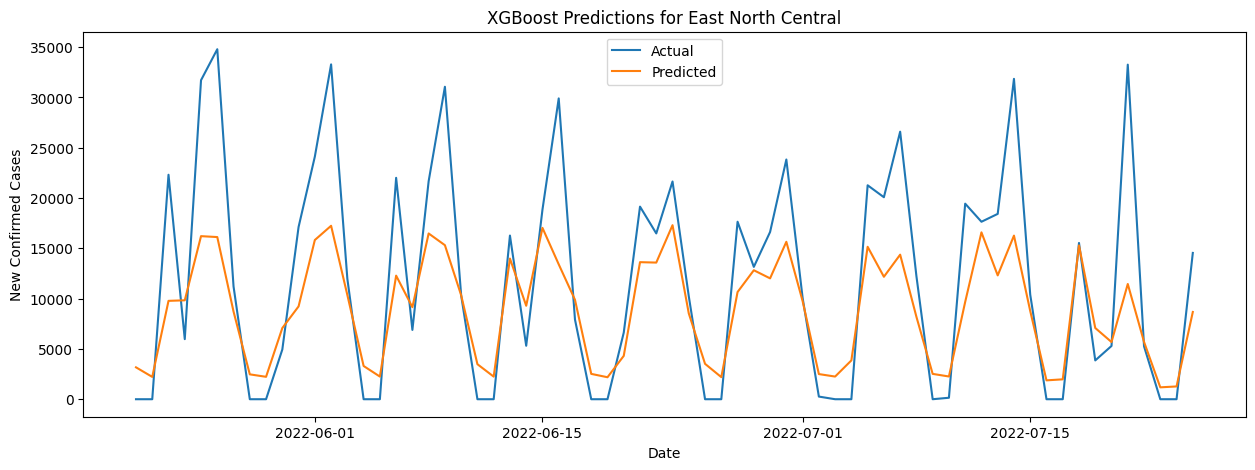



Training model for East South Central...
MAE: 721.85
RMSE: 1384.76
MASE: 0.48


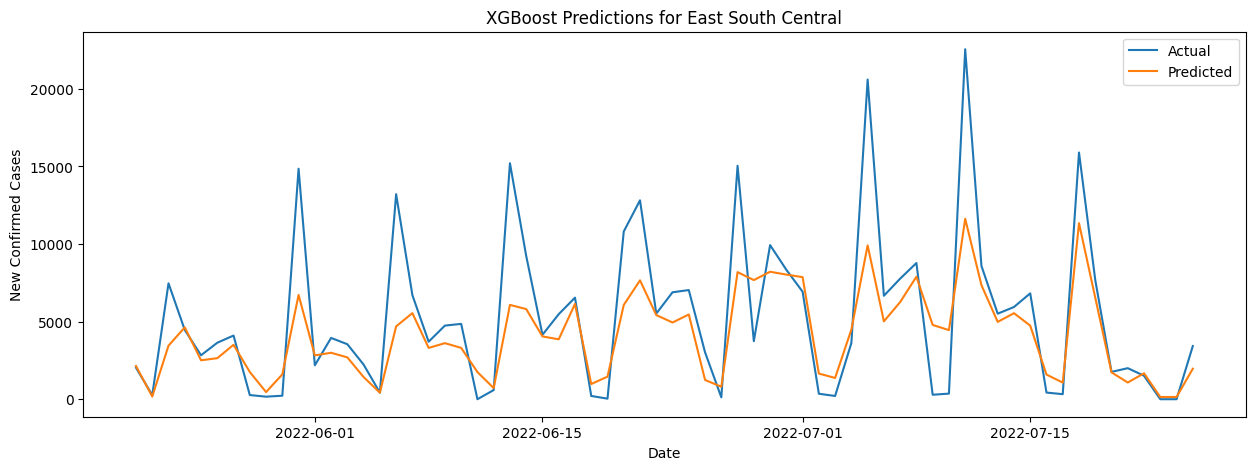



Training model for Mid-Atlantic...
MAE: 2166.45
RMSE: 3220.35
MASE: 0.8


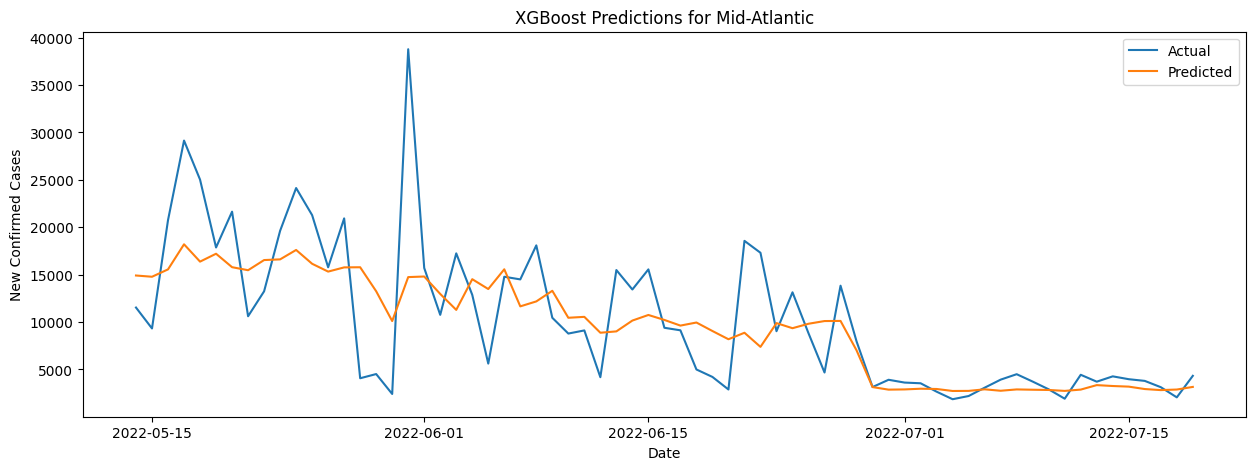



Training model for Mountain...
MAE: 622.08
RMSE: 1626.74
MASE: 0.57


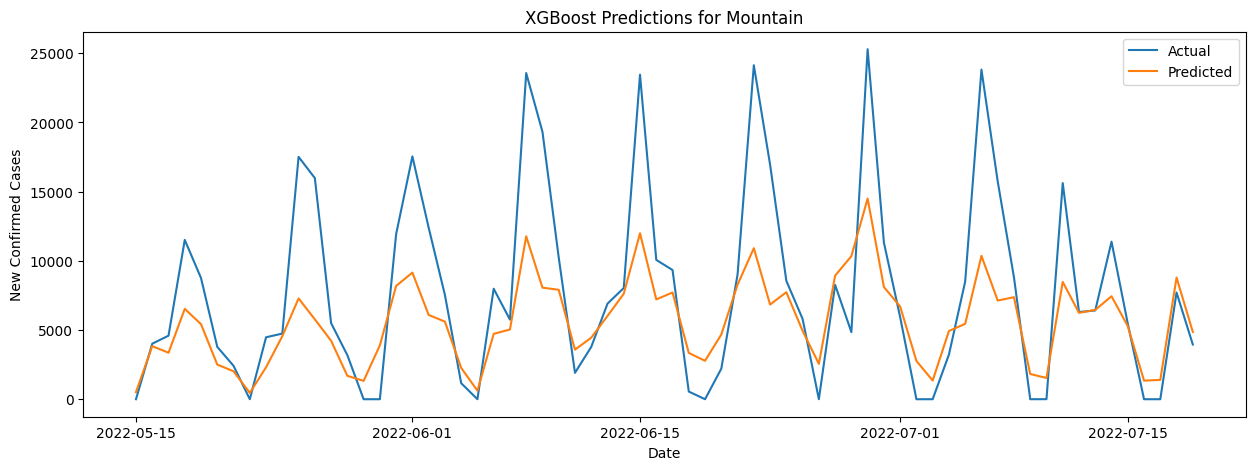



Training model for New England...
MAE: 285.95
RMSE: 1148.01
MASE: 0.29


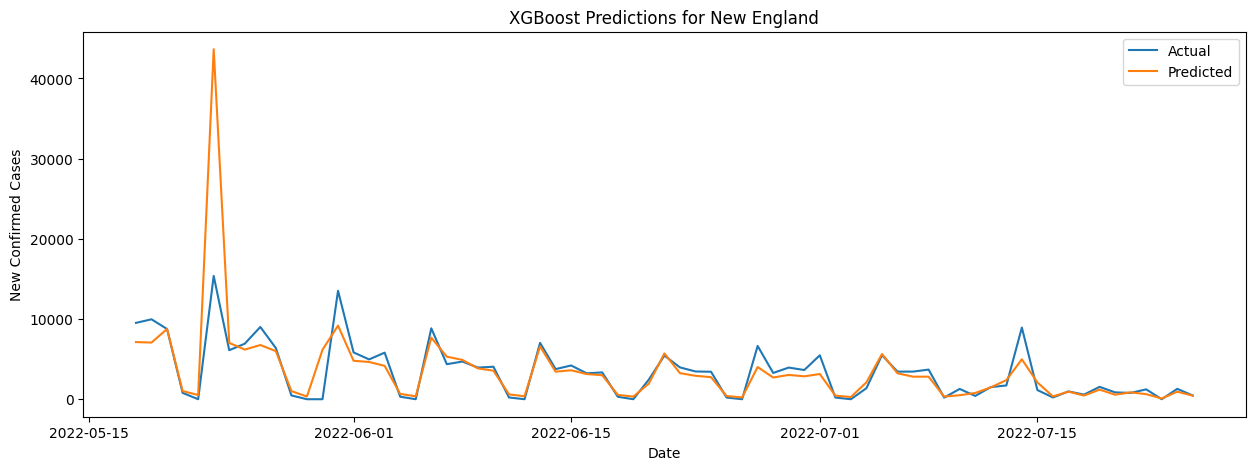



Training model for Pacific...
MAE: 3584.7
RMSE: 7793.37
MASE: 0.72


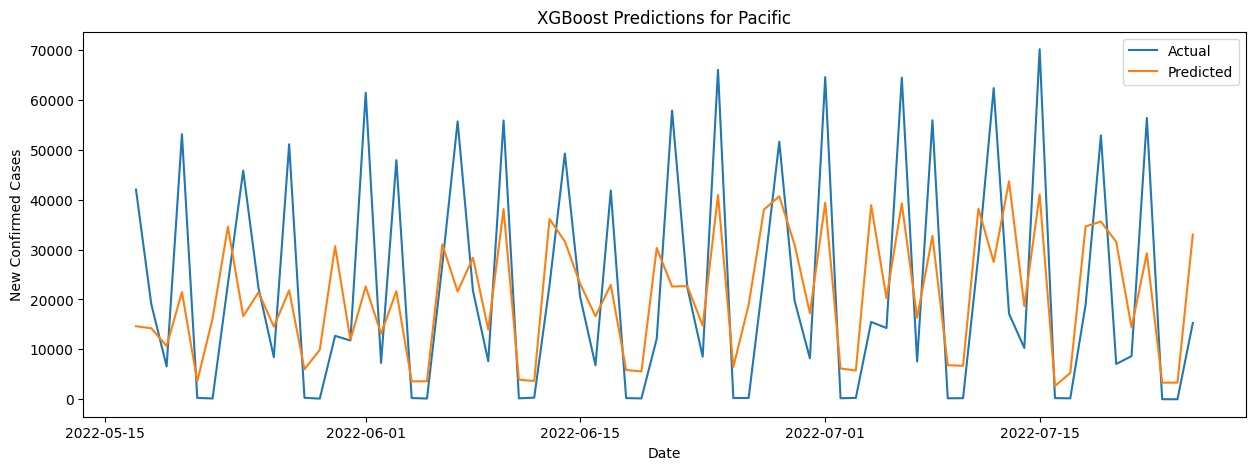



Training model for South Atlantic...
MAE: 1447.71
RMSE: 3302.72
MASE: 0.49


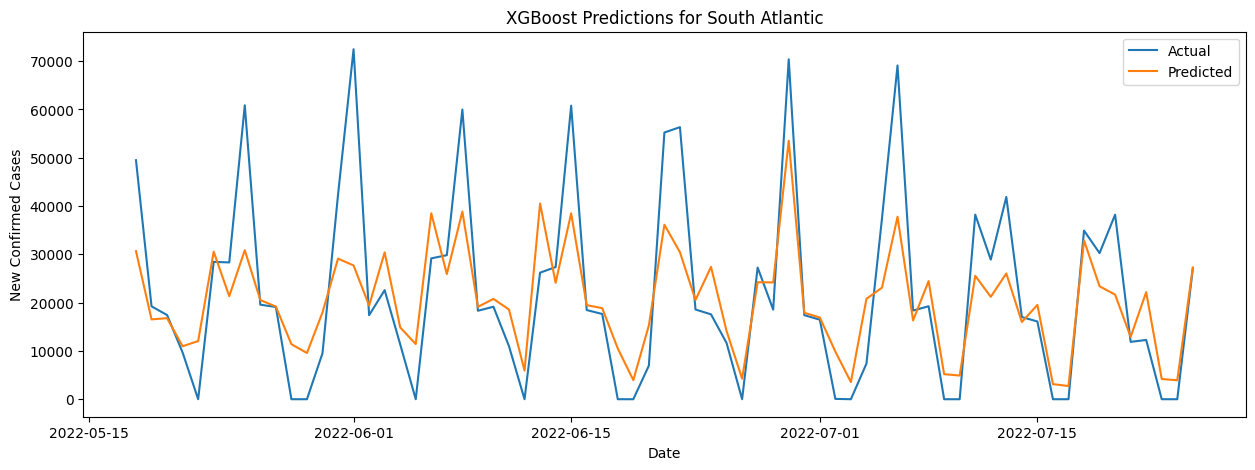



Training model for West North Central...
MAE: 501.26
RMSE: 1183.75
MASE: 0.45


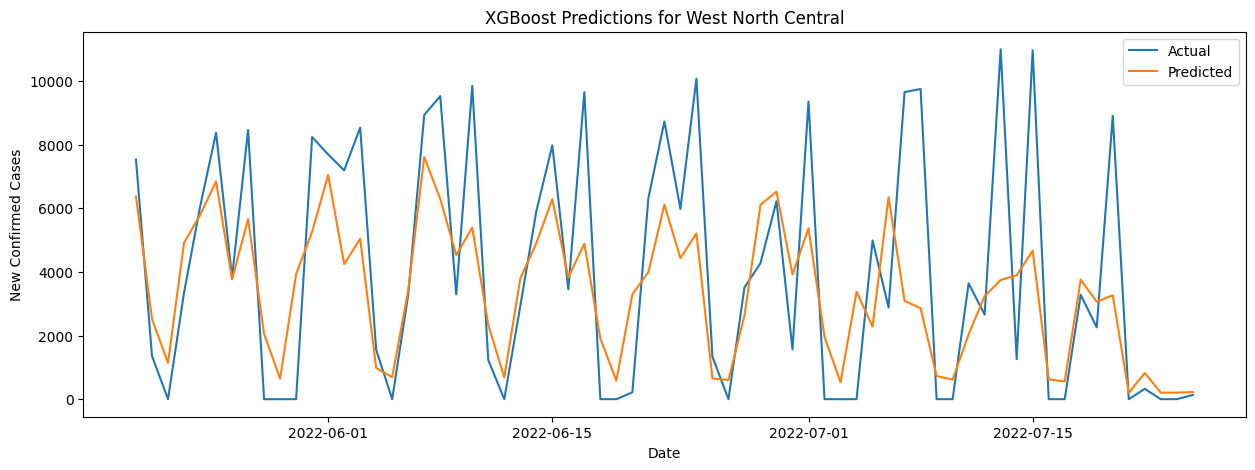



Training model for West South Central...
MAE: 1505.22
RMSE: 2403.35
MASE: 0.36


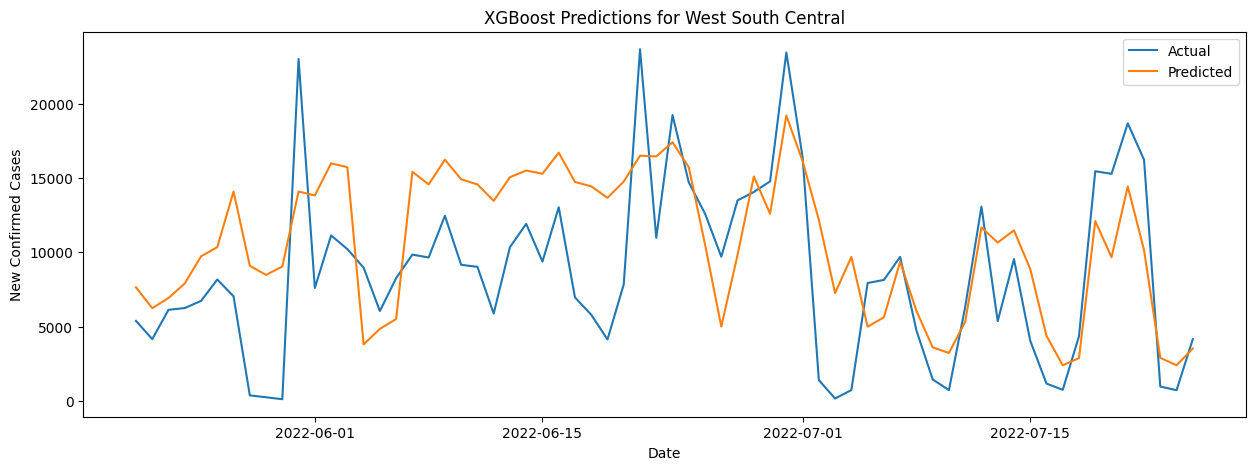



--- 11.92 seconds ---


,region,mase,rmse,mae
0,East North Central,0.634782,3075.254052,1496.446688
1,East South Central,0.479011,1384.761487,721.852680
2,Mid-Atlantic,0.795070,3220.351678,2166.453031
3,Mountain,0.572018,1626.741357,622.084929
4,New England,0.288302,1148.014306,285.954416
5,Pacific,0.720592,7793.366882,3584.702194
6,South Atlantic,0.494479,3302.717845,1447.710557
7,West North Central,0.448063,1183.754473,501.255088
8,West South Central,0.359180,2403.347134,1505.217218


In [128]:
start_time = time.time()
results = []
for df in datasets:
    region, mase, rmse, mae = train_baseline_model(df, plot=True)
    print("\n")
    results.append([region, mase, rmse, mae])
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

results = pd.DataFrame(results, columns=['region', 'mase', 'rmse', 'mae'])
results

## Feature Selection

In [129]:
def feature_selection(df, feature_perc=0.95):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df.sort_index(inplace=True)

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    # test_df = df[df.index.normalize().isin(test_days)]

    # train_df, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    # val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    train = train_df
    test = validation_df

    X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_train = train[features]
    y_train = train['new_confirmed']
    # y_train_log = np.log(y_train)
    # y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, early_stopping_rounds=10,)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
     

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    return region, list(important_features.index)

In [130]:
first_fs = {}
for df in datasets:
    region, features = feature_selection(df)
    first_fs[region] = features
    print("\n")


Training model for East North Central...
Number of features for 95.0% importance: 31, out of 62


Training model for East South Central...
Number of features for 95.0% importance: 36, out of 62


Training model for Mid-Atlantic...
Number of features for 95.0% importance: 26, out of 61


Training model for Mountain...
Number of features for 95.0% importance: 36, out of 65


Training model for New England...
Number of features for 95.0% importance: 26, out of 62


Training model for Pacific...
Number of features for 95.0% importance: 16, out of 63


Training model for South Atlantic...
Number of features for 95.0% importance: 31, out of 66


Training model for West North Central...
Number of features for 95.0% importance: 35, out of 64


Training model for West South Central...
Number of features for 95.0% importance: 21, out of 60




In [131]:
first_fs

{'East North Central': ['7_day_shift',
  'stringency_index',
  '7_day_avg',
  'dayofyear',
  'new_deceased',
  'average_temperature_celsius',
  'year',
  '2_day_shift',
  'cumulative_persons_vaccinated',
  'cumulative_persons_fully_vaccinated_pfizer',
  '1_day_shift',
  'new_persons_fully_vaccinated_janssen',
  'school_closing',
  'cumulative_persons_fully_vaccinated',
  'new_persons_fully_vaccinated_pfizer',
  'cumulative_persons_fully_vaccinated_moderna',
  'international_travel_controls',
  'relative_humidity',
  'new_hospitalized_patients',
  'location_key_US_OH',
  'income_support',
  'cumulative_confirmed',
  'cumulative_hospitalized_patients',
  'cumulative_deceased',
  'day',
  'location_key_US_MI',
  'weekofyear',
  'new_persons_vaccinated',
  'rainfall_mm',
  'new_vaccine_doses_administered_moderna',
  'maximum_temperature_celsius'],
 'East South Central': ['7_day_shift',
  '7_day_avg',
  '1_day_shift',
  'new_deceased',
  '2_day_shift',
  'day',
  'location_key_US_AL',
  'st

In [132]:
def train_model_with_features(df, features, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    # size = round(df.shape[0]*0.15)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    train = train_df
    test = validation_df

    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(actual, y_pred_gb)
    mse = mean_squared_error(actual, y_pred_gb)
    rmse = mean_squared_error(actual, y_pred_gb, squared=False)
    mase = mean_absolute_scaled_error(actual, y_pred_gb, y_train=y_train_gb)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region} on Validation Set')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

    # stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    # stats = stats.sort_values('importance', ascending=False)  
    # stats = stats.sort_values('importance', ascending=False)
    # stats["cum_importance"] = np.cumsum(stats['importance'])

    # n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    # important_features = stats[:n_percent] 
    # print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    # print(f"Important features: {list(important_features.index)}")


In [133]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_fs[region]
    train_model_with_features(df, features, plot=False)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 3604.84
MSE: 29918215.63
RMSE: 5469.75
MASE: 0.42


Training model for East South Central...
MAE: 739.45
MSE: 1118268.91
RMSE: 1057.48
MASE: 0.21


Training model for Mid-Atlantic...
MAE: 2113.64
MSE: 11368245.29
RMSE: 3371.68
MASE: 0.97


Training model for Mountain...
MAE: 1335.54
MSE: 8110891.41
RMSE: 2847.96
MASE: 0.4


Training model for New England...
MAE: 1075.7
MSE: 3643935.43
RMSE: 1908.91
MASE: 0.42


Training model for Pacific...
MAE: 4407.65
MSE: 28195210.03
RMSE: 5309.92
MASE: 0.66


Training model for South Atlantic...
MAE: 4806.76
MSE: 34924130.46
RMSE: 5909.66
MASE: 0.44


Training model for West North Central...
MAE: 708.23
MSE: 1167359.8
RMSE: 1080.44
MASE: 0.21


Training model for West South Central...
MAE: 2804.14
MSE: 10271918.56
RMSE: 3204.98
MASE: 0.59


--- 14.49 seconds ---


## Parameter Tuning

In [134]:
def parameter_tune(df, features=None,):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.2)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    
    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    # test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    # test_df = df[df.index.normalize().isin(test_days)]
    
    train = train_df
    test = validation_df

    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    if features:
        X_train = train[features]
        X_test = test[features]
    else:
        X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
        X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    
    y_train = train['new_confirmed']
    y_test = test['new_confirmed']

    # fit model
    results_df = pd.DataFrame(columns=['Learning Rate', 'N Estimators', 'Depth', 'MAE', 'RMSE', 'MASE'])
    max_depths =  [2, 3, 5, 8, None]
    # learning_rates = [0.01, 0.05, 0.1, 0.15]
    learning_rates = [0.05, 0.1, 0.25, 0.5]
    # n_estimators = [250, 500, 1000]
    n_estimators = [25, 50, 100, 250, 500, 1000]
    # subsample = [0.7, 0.8, 0.9]
    for lr in learning_rates:
        for n_est in n_estimators:
            for depth in max_depths:
                if depth == None:
                    model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, early_stopping_rounds=10, n_jobs=-1)
                else:
                    model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, early_stopping_rounds=10, n_jobs=-1)
                
                model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)], 
                        verbose=False)
                

                # make predictions
                y_pred = model.predict(X_test)

                actual = y_test.groupby(y_test.index).sum()
                y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
                y_train_gb = y_train.groupby(y_train.index).sum()

                # calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                # mse = mean_squared_error(actual, y_pred_gb)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

                results_df = results_df.append({'Learning Rate': lr, 'N Estimators': n_est, 'Depth': depth,
                                            'MAE': mae, 'RMSE': rmse, 'MASE': mase}, 
                                        ignore_index=True)
    results_df = results_df.sort_values('MASE')
    print(results_df.head(1))
    return region, {"learning_rate": results_df['Learning Rate'].iloc[0],
                    "n_estimators": results_df['N Estimators'].iloc[0],
                    "max_depth": results_df['Depth'].iloc[0]}

In [135]:
start_time = time.time()
params = {}
for df in datasets:
    region = df["region"].iloc[0]
    # features = baseline_fs[region]["features"]
    region, best = parameter_tune(df, features=first_fs[region])
    params[region] = best
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")
params

Training model for East North Central...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
18           0.05         250.0    8.0  783.419178  2128.557457  0.332321


Training model for East South Central...
    Learning Rate  N Estimators  Depth         MAE        RMSE      MASE
16           0.05         250.0    3.0  209.097793  366.323217  0.138754


Training model for Mid-Atlantic...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
68           0.25          50.0    8.0  924.259644  1793.438644  0.339196


Training model for Mountain...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
98            0.5          50.0    8.0  222.963722  1008.433601  0.205019


Training model for New England...
    Learning Rate  N Estimators  Depth         MAE        RMSE      MASE
22           0.05         500.0    5.0  222.882016  542.460903  0.224712


Training model for Pacific...
     Learning Rate  N Estimators  Depth   

{'East North Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 8.0},
 'East South Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 3.0},
 'Mid-Atlantic': {'learning_rate': 0.25,
  'n_estimators': 50.0,
  'max_depth': 8.0},
 'Mountain': {'learning_rate': 0.5, 'n_estimators': 50.0, 'max_depth': 8.0},
 'New England': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 5.0},
 'Pacific': {'learning_rate': 0.5, 'n_estimators': 1000.0, 'max_depth': nan},
 'South Atlantic': {'learning_rate': 0.25,
  'n_estimators': 1000.0,
  'max_depth': 3.0},
 'West North Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 8.0},
 'West South Central': {'learning_rate': 0.5,
  'n_estimators': 1000.0,
  'max_depth': 5.0}}

# Final Model

In [136]:
params={'East North Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 8.0},
 'East South Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 3.0},
 'Mid-Atlantic': {'learning_rate': 0.25,
  'n_estimators': 50.0,
  'max_depth': 8.0},
 'Mountain': {'learning_rate': 0.5, 'n_estimators': 50.0, 'max_depth': 8.0},
 'New England': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 5.0},
 'Pacific': {'learning_rate': 0.5, 'n_estimators': 1000.0, 'max_depth': None},
 'South Atlantic': {'learning_rate': 0.25,
  'n_estimators': 1000.0,
  'max_depth': 3.0},
 'West North Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 8.0},
 'West South Central': {'learning_rate': 0.5,
  'n_estimators': 1000.0,
  'max_depth': 5.0}}

In [137]:
def final_model(df, params, features, plot=False,):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    # features = params["features"]
    if features is None:
        features = df.drop(columns=['new_confirmed', 'region', 'location_key']).columns
    n_estimators = int(params["n_estimators"])
    learning_rate = params["learning_rate"]
    depth = int(params["max_depth"]) if params["max_depth"] else None

    print(f"Number of features: {len(features)}")

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    test_df = df[df.index.normalize().isin(test_days)]

    train = train_df # pd.concat([train_df, validation_df])
    test = test_df
    valid = validation_df


    X_train = train[features]
    y_train = train['new_confirmed']

    X_valid = valid[features]
    y_valid = valid['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    if depth == None:
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, early_stopping_rounds=10)
    else:
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=depth, early_stopping_rounds=10)

    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            verbose=False)
    print(f"Model Params: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={depth}, early_stopping_rounds=10")
    

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    # mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region} on {"Test"} Set')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

    return region, mase, rmse, mae
        

Training model for East North Central...
Number of features: 31
Model Params: n_estimators=250, learning_rate=0.05, max_depth=8, early_stopping_rounds=10
MAE: 1447.91
RMSE: 3573.66
MASE: 0.61


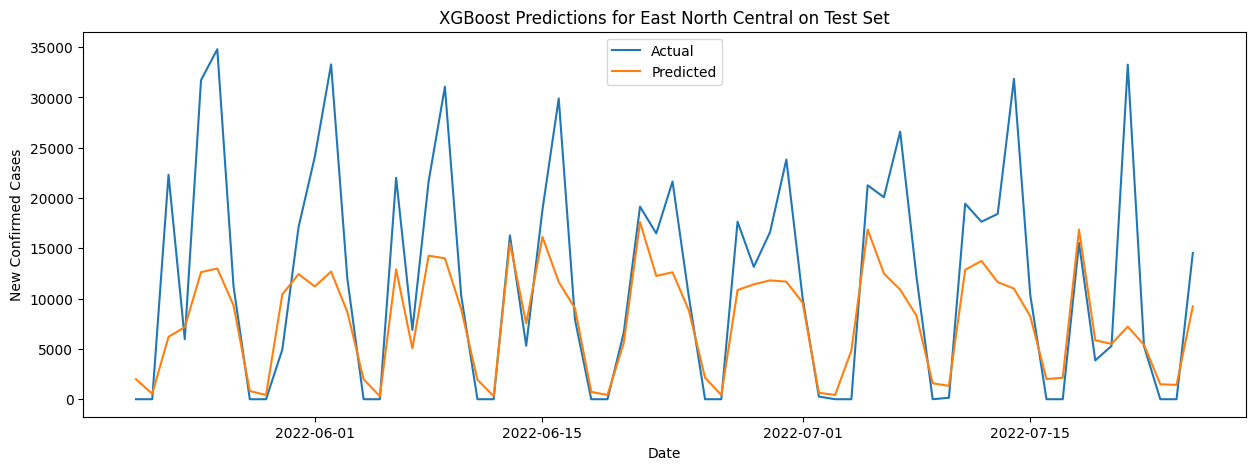


Training model for East South Central...
Number of features: 36
Model Params: n_estimators=250, learning_rate=0.05, max_depth=3, early_stopping_rounds=10
MAE: 812.17
RMSE: 1444.59
MASE: 0.54


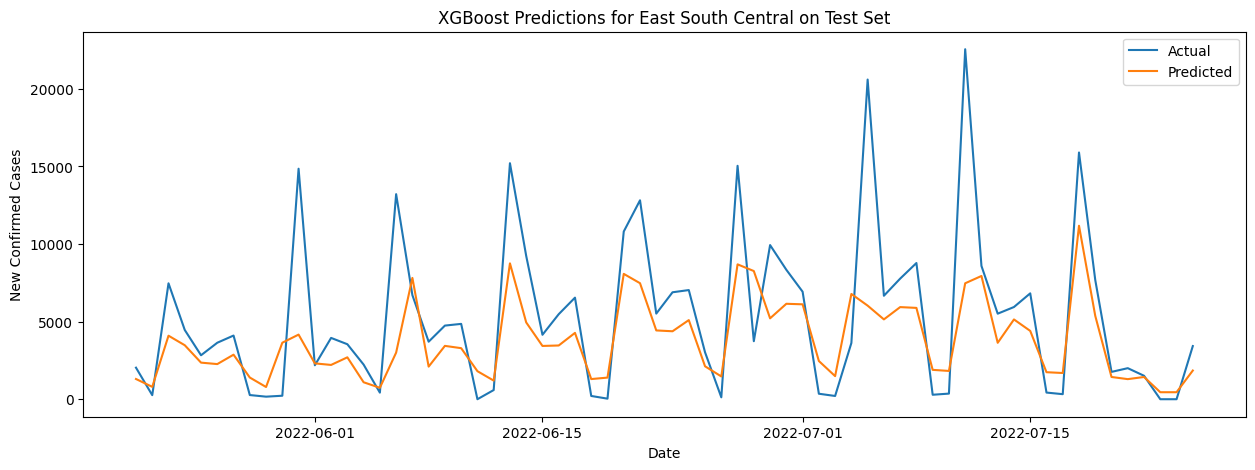


Training model for Mid-Atlantic...
Number of features: 26
Model Params: n_estimators=50, learning_rate=0.25, max_depth=8, early_stopping_rounds=10
MAE: 2110.82
RMSE: 3134.94
MASE: 0.77


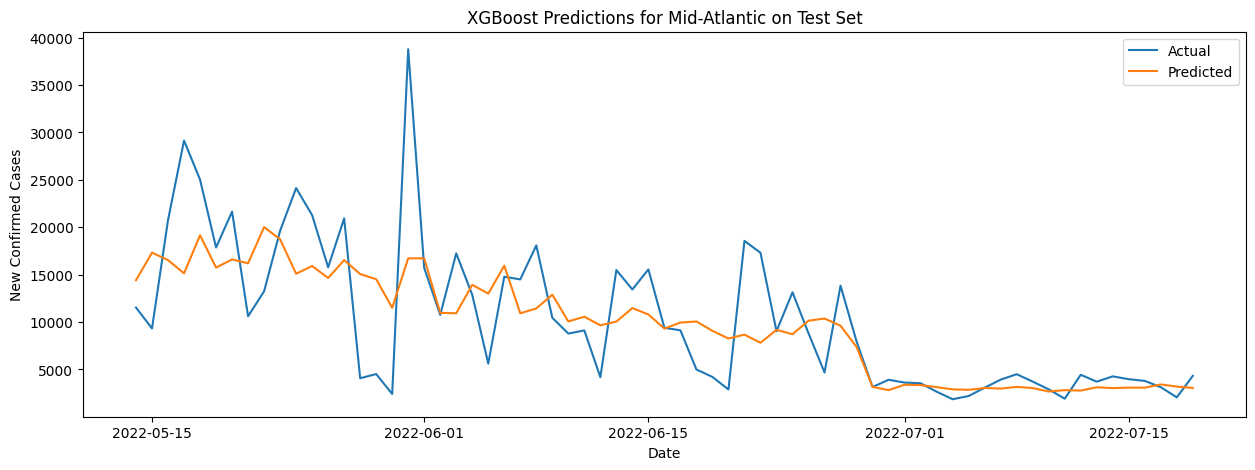


Training model for Mountain...
Number of features: 36
Model Params: n_estimators=50, learning_rate=0.5, max_depth=8, early_stopping_rounds=10
MAE: 601.05
RMSE: 1737.65
MASE: 0.55


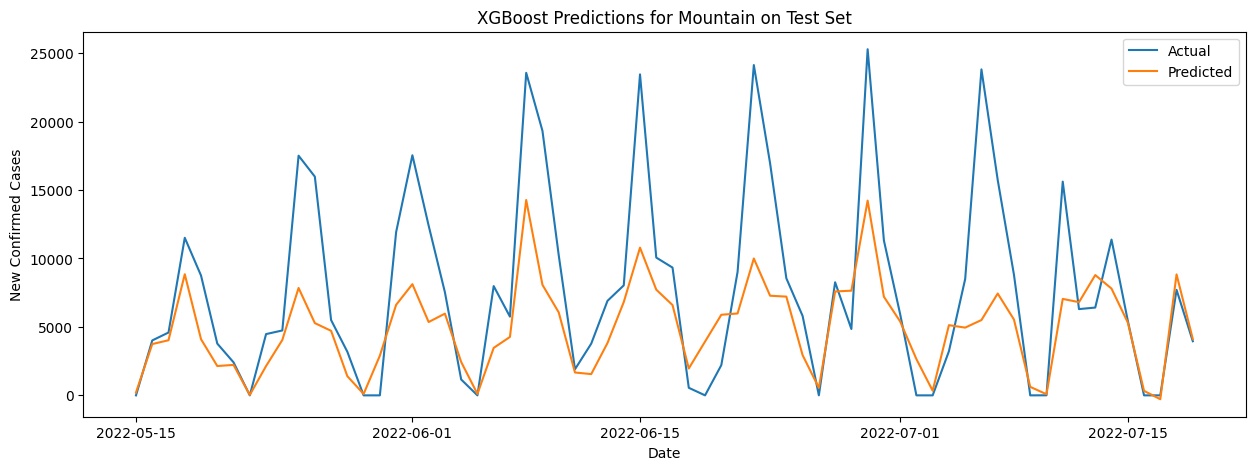


Training model for New England...
Number of features: 26
Model Params: n_estimators=500, learning_rate=0.05, max_depth=5, early_stopping_rounds=10
MAE: 293.18
RMSE: 959.68
MASE: 0.3


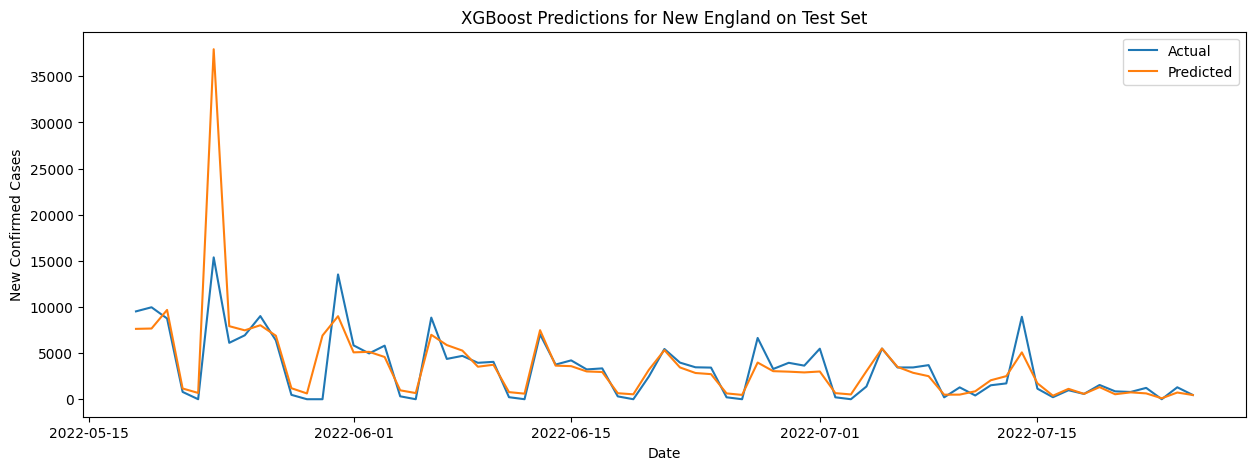


Training model for Pacific...
Number of features: 16
Model Params: n_estimators=1000, learning_rate=0.5, max_depth=None, early_stopping_rounds=10
MAE: 3328.43
RMSE: 7396.71
MASE: 0.67


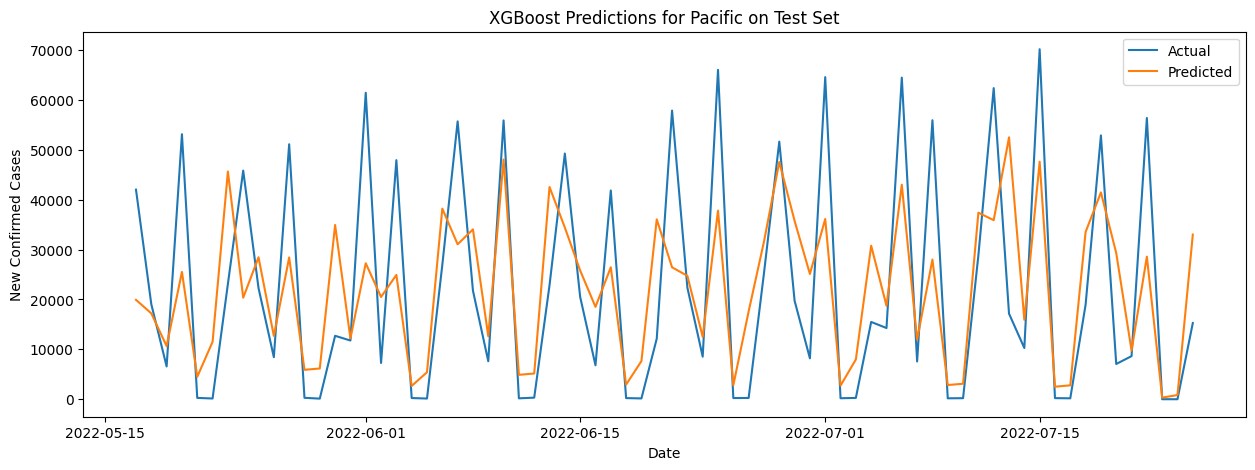


Training model for South Atlantic...
Number of features: 31
Model Params: n_estimators=1000, learning_rate=0.25, max_depth=3, early_stopping_rounds=10
MAE: 1462.31
RMSE: 3568.16
MASE: 0.5


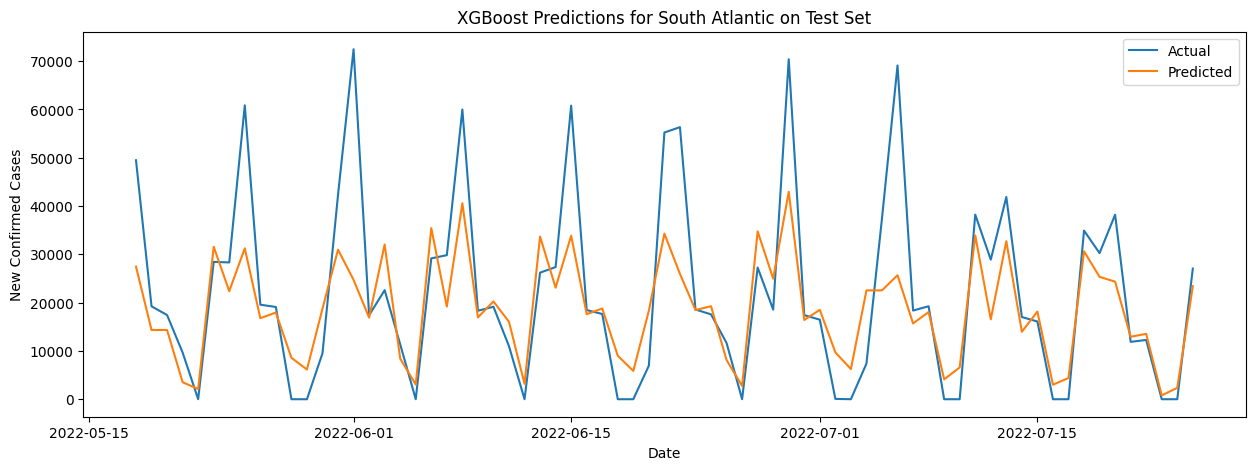


Training model for West North Central...
Number of features: 35
Model Params: n_estimators=250, learning_rate=0.05, max_depth=8, early_stopping_rounds=10
MAE: 484.45
RMSE: 1150.24
MASE: 0.43


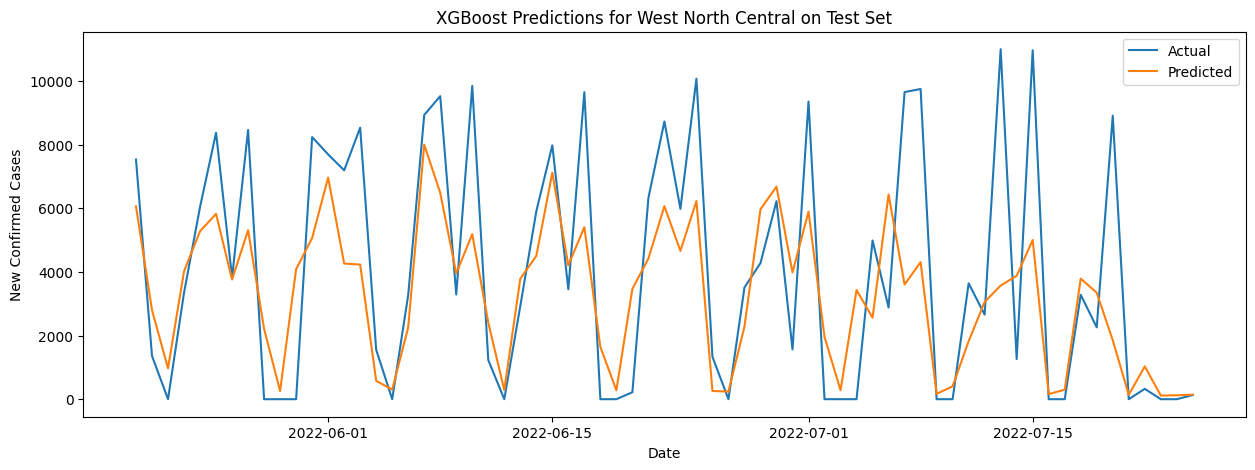


Training model for West South Central...
Number of features: 21
Model Params: n_estimators=1000, learning_rate=0.5, max_depth=5, early_stopping_rounds=10
MAE: 1107.7
RMSE: 2154.67
MASE: 0.26


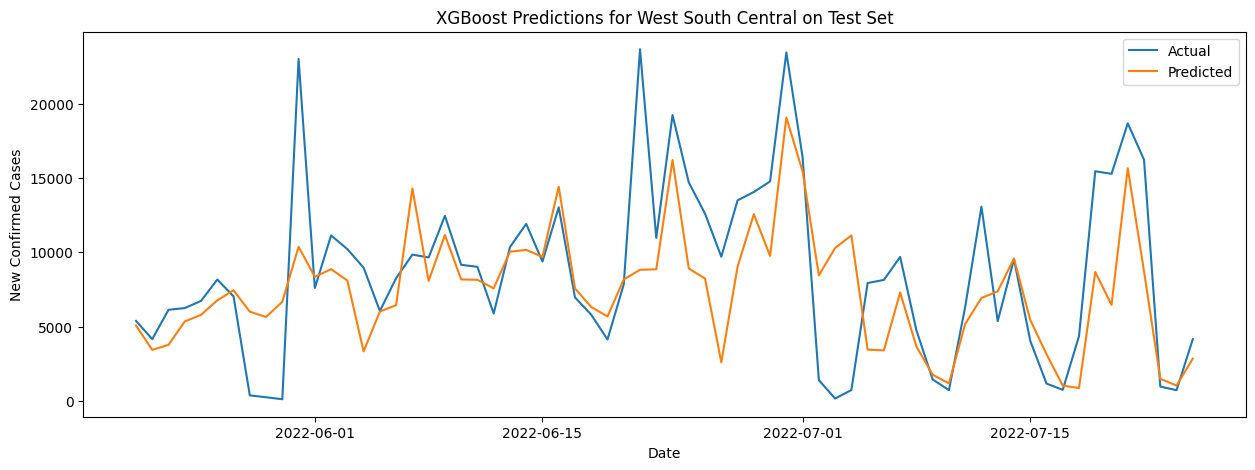


--- 7.13 seconds ---


,Region,MASE,RMSE,MAE
0,East North Central,0.614192,3573.657268,1447.906905
1,East South Central,0.538947,1444.593026,812.174621
2,Mid-Atlantic,0.774655,3134.939158,2110.823001
3,Mountain,0.552676,1737.645216,601.049978
4,New England,0.295592,959.676686,293.184877
5,Pacific,0.669077,7396.705933,3328.431572
6,South Atlantic,0.499465,3568.162130,1462.309917
7,West North Central,0.433045,1150.236634,484.454024
8,West South Central,0.264323,2154.666011,1107.698593


In [138]:
start_time = time.time()
results = []
for df in datasets:
    region = df["region"].iloc[0]
    params_tmp = params[region]
    region, mase, rmse, mae = final_model(df, params_tmp, features=first_fs[region], plot=True)
    results.append((region, mase, rmse, mae))
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

results = pd.DataFrame(results, columns=["Region", "MASE", "RMSE", "MAE"])
results